In [ ]:
# We implement 1 Inception Modules used in GoogLe net, and test out on the MIT pictures dataset.
# This may serve as our test bed for GPU computations.
# Model Architecture -- input - inception module - fully connected layer - output. 
# As a test, we will train this on MNIST.

# Result: the model overfits the training data but doesn't generalize well. Modifying learning rates has some impact,
# highest accuracy on validation set being about 70-75%. Stringing together a couple inception modules may help improve
# the accuracy but even a single one takes some time to run.

# Next we import the pretrained inception v3, and run it on this convnet. As one final test, we add a fully connected
# layer at the beginning of the inception module.

In [1]:
% matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# MNIST parameters
height = 28
width = 28
channels = 1
n_inputs = height*width

print(np.sqrt(2.)/np.sqrt(n_inputs))

In [ ]:
# Kernel sizes and # feature maps for convolutions in num*num format
# We add a convolutional layer 0 with 32 filter maps to the front of the data before going into the bottleneck inception layers
kern_conv0 = 2
kern_conv1 = 1
kern_conv2a = 1
kern_conv2b = 3
kern_conv3a = 1
kern_conv3b = 5
pool_kern4a = 3
kern_conv4b = 1

filter_maps_0 = 32
filter_maps = 32
filter_maps_bottleneck = 16
fully_connected_maps = 300
fully_connected_maps_2 = 10
dropout_rate = 0.5

In [ ]:
# Compute the Number of parameters in the model: in this model we only have one depth as the inputs are Greys.

n_params_incept = (kern_conv1**2)*filter_maps + (kern_conv2a**2)*filter_maps_bottleneck + (kern_conv2b**2)*filter_maps
+  (kern_conv3a**2)*filter_maps_bottleneck + (kern_conv3b**2)*filter_maps + (kern_conv4b**2)*filter_maps 
      
print(28*28*300, n_params_incept)
# significantly fewer parameters as far fewer feature maps. Try increasing number of feature maps. 

In [ ]:
tf.reset_default_graph()
# reduce batch size from 100 to free up computational memory. 
batch_size = 50
# Number of computations -- since all of these go into each of the layers at once:

n_compute = batch_size*(28**2)*n_params_incept
print("Number of Computations = ", n_compute)

X = tf.placeholder(tf.float32, shape = [None, height, width, channels], name = "X")
y = tf.placeholder(tf.int32, shape = [None], name = "y")
training = tf.placeholder_with_default(False, shape = [], name = 'training')

In [ ]:
def create_weights(size):
    return tf.Variable(tf.truncated_normal(size, stddev =0.05)) # 0.05 comes from Xavier Initialization for weights. 

def create_bias(size):
    return tf.Variable(tf.constant(0.1, shape = size))

weights = {
    'w_0': create_weights([kern_conv0, kern_conv0, channels, filter_maps_0]),
    'w_1': create_weights([kern_conv1,kern_conv1, filter_maps_0, filter_maps]),
    'w_2a': create_weights([kern_conv2a, kern_conv2a, filter_maps_0, filter_maps_bottleneck]),
    'w_2b': create_weights([kern_conv2b, kern_conv2b, filter_maps_bottleneck, filter_maps]),
    'w_3a': create_weights([kern_conv3a, kern_conv3a, filter_maps_0, filter_maps_bottleneck]),
    'w_3b': create_weights([kern_conv3b, kern_conv3b, filter_maps_bottleneck, filter_maps]),
    'w_4': create_weights([kern_conv4b, kern_conv4b, filter_maps_0, filter_maps]),
}

biases = {
    'b_0': create_bias([filter_maps_0]),
    'b_1': create_bias([filter_maps]),
    'b_2a': create_bias([filter_maps_bottleneck]),
    'b_2b': create_bias([filter_maps]),
    'b_3a': create_bias([filter_maps_bottleneck]),
    'b_3b': create_bias([filter_maps]),
    'b_4': create_bias([filter_maps]),
}


In [ ]:
# Take this out for now. 
initial_learning_rate = 0.001
decay_steps = 10000
decay_rate = 1/10


In [ ]:
# Make Inception Module with a dropout layer with 50% dropout. To stack another inception module, just define more weights
# and filters. 

def make_inception_network(X):
    
    conv_0 = tf.nn.conv2d(X, weights['w_0'], strides =[1, 1, 1, 1], padding = "SAME")
    conv_0 = tf.nn.bias_add(conv_0, biases['b_0'])
    conv_0 = tf.nn.relu(conv_0)
    pool1 = tf.nn.max_pool(conv_0, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = "SAME")
    
    conv_1 = tf.nn.conv2d(pool1, weights['w_1'], strides =[1, 1, 1, 1], padding = "SAME")
    conv_1 = tf.nn.bias_add(conv_1, biases['b_1'])
    conv_1 = tf.nn.relu(conv_1)
    
    conv_2a = tf.nn.conv2d(pool1, weights['w_2a'], strides =[1, 1, 1, 1], padding = "SAME")
    conv_2a = tf.nn.bias_add(conv_2a, biases['b_2a'])
    conv_2a = tf.nn.relu(conv_2a)
    
    conv_2b = tf.nn.conv2d(conv_2a, weights['w_2b'], strides =[1, 1, 1, 1], padding = "SAME")
    conv_2b = tf.nn.bias_add(conv_2b, biases['b_2b'])
    conv_2b = tf.nn.relu(conv_2b)

    conv_3a = tf.nn.conv2d(pool1, weights['w_3a'], strides =[1, 1, 1, 1], padding = "SAME")
    conv_3a = tf.nn.bias_add(conv_3a, biases['b_3a'])
    conv_3a = tf.nn.relu(conv_3a)
    
    conv_3b = tf.nn.conv2d(conv_3a, weights['w_3b'], strides =[1, 1, 1, 1], padding = "SAME")
    conv_3b = tf.nn.bias_add(conv_3b, biases['b_3b'])
    conv_3b = tf.nn.relu(conv_3b)

    with tf.name_scope("pool"):
        max_pool = tf.nn.max_pool(pool1, ksize = [1, pool_kern4a, pool_kern4a, 1], strides = [1, 1, 1, 1], padding = "SAME")
        conv_4b = tf.nn.conv2d(max_pool, weights['w_4'], strides =[1, 1, 1, 1], padding = "SAME")
        conv_4b = tf.nn.bias_add(conv_4b, biases['b_4'])
        conv_4b = tf.nn.relu(conv_4b)
    
    
    inception = tf.nn.relu(tf.concat([conv_1, conv_2b, conv_3b, conv_4b], axis = 3))
    incep_shape = inception.get_shape().as_list()

    inception_reshape = tf.reshape(inception, shape =[-1, incep_shape[1]*incep_shape[2]*incep_shape[3]]) # 4 from the 4 conv layers.

    fully_connected_inception = tf.layers.dense(inception_reshape, units = fully_connected_maps, activation = tf.nn.relu)
    fc_drop = tf.layers.dropout(fully_connected_inception, dropout_rate, training=training)
    print("is this working")
    
    logits = tf.layers.dense(fc_drop, units = fully_connected_maps_2)
    Y_proba = tf.nn.softmax(logits, name = "Y_proba")
    
    return logits
# We introduce a regularization to avoid over fitting. Also perform learning rate scheduling

with tf.name_scope("train"):
    logits = make_inception_network(X)
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    #regularizer = tf.nn.l2_loss(weights['w_1']) + tf.nn.l2_loss(weights['w_2a']) + tf.nn.l2_loss(weights['w_2b']) + tf.nn.l2_loss(weights['w_3a']) + tf.nn.l2_loss(weights['w_3b']) + tf.nn.l2_loss(weights['w_4'])                   
    loss = tf.reduce_mean(xentropy, name ="loss")
    global_step = tf.Variable(0, trainable= False)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.01)
    training_op = optimizer.minimize(loss, global_step = global_step)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
#    saver = tf.train.Saver()    

In [ ]:
# Now we test this code on MNIST:

#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data")

# Let's also try on the MNISt dataset from scikit learn.

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
Xdata = mnist["data"]
ydata = mnist["target"]

np.random.seed(42)
shuffle_idx = np.random.permutation(60000)
X_data = Xdata[shuffle_idx]
y_data = ydata[shuffle_idx]

X_train = X_data[:50000]
y_train = y_data[:50000].astype(np.int32)
X_val = X_data[50000:]
y_val = y_data[50000:].astype(np.int32)

In [ ]:
#X_train = mnist.train.images
#X_val = mnist.validation.images
#val_ave = np.mean(X_val)
#val_std = np.std(X_val)
#X_test = mnist.test.images
#test_ave = np.mean(X_test)
#test_std = np.std(X_test)


#y_train = mnist.train.labels.astype("int32")
#y_val = mnist.validation.labels.astype("int32")
#y_test = mnist.test.labels.astype("int32")

# Don't subtract mean and std dev from dataset. conv2d does that automatically. 
#X_val_final = np.reshape(((X_val - val_ave)/(val_std)), [len(X_val), height, width, channels])
#X_test_final = np.reshape(((X_test - test_ave)/(test_std)), [len(X_test), height, width, channels])
#X_test_norm = (X_test_final - np.mean(X_test_final, keepdims = True))/(np.std(X_test_final, keepdims = True)).astype(np.float32)
#print(len(X_train), len(X_test), X_test_final.shape)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_scaled_val = scaler.fit_transform(X_val.astype(np.float32))
mean = np.mean(X_scaled)
mean_val = np.mean(X_scaled_val)
std = np.std(X_scaled)
std_val = np.std(X_scaled_val)

X_train_scaled = (X_scaled - mean)/std
X_val_scaled = np.reshape((X_scaled_val - mean_val)/std_val, (-1, 28, 28, 1))

In [ ]:
#np.random.seed(42)
#shuffle_index = np.random.permutation(len(X_train))
#X_train_shuffled = X_train[shuffle_index]
#X_train_shuffled_reshape = np.reshape(X_train_shuffled, [len(X_train), 28, 28, 1])
#y_train_shuffled = y_train[shuffle_index]

In [ ]:
fig = plt.figure()
plt.subplot(221)
plot_test = np.reshape(X_scaled[260], (28, 28))
plt.imshow(plot_test, cmap = 'Greys' , interpolation = 'nearest', label = 'Training Digits')
#print(y_train[260], type(y_train[260]))
#print((X_train_scaled).shape)
plt.subplot(222)
plot_test = np.reshape(X_scaled[1001], (28, 28))
plt.imshow(plot_test, cmap = 'Greys' , interpolation = 'nearest', label = 'Training Digits')
#print(y_train[260], type(y_train[260]))
#print((X_train_scaled).shape)
plt.subplot(223)
plot_test = np.reshape(X_scaled[20000], (28, 28))
plt.imshow(plot_test, cmap = 'Greys' , interpolation = 'nearest', label = 'Training Digits')
#print(y_train[260], type(y_train[260]))
#print((X_train_scaled).shape)
plt.subplot(224)
plot_test = np.reshape(X_scaled[25000], (28, 28))
plt.imshow(plot_test, cmap = 'Greys' , interpolation = 'nearest', label = 'Training Digits')
#print(y_train[260], type(y_train[260]))
print((X_train_scaled).shape)#
plt.suptitle('Sample Training Images')

In [ ]:
# Plot the training images
plt.figure()
one_train_images=[] 
for iter in range(4):
    one_train_images.append(np.reshape(X_train_shuffled[iter+250], (28, 28)))

plt.subplot(221)
plt.imshow(one_train_images[0], cmap = 'Greys', interpolation = 'nearest')
plt.axis("off")
plt.subplot(222)
plt.imshow(one_train_images[1], cmap = 'Greys', interpolation = 'nearest')
plt.axis("off")
plt.subplot(223)
plt.imshow(one_train_images[2], cmap = 'Greys', interpolation = 'nearest')
plt.axis("off")
plt.subplot(224)
plt.imshow(one_train_images[3], cmap = 'Greys', interpolation = 'nearest')
plt.axis("off")
plt.show()

In [ ]:
# With the shuffled training set, we are now ready to make batches. We zero mean and unit std dev the batches. 
# Validation/Test data also has unit mean and 1 std.
batch_size = 50
def fetch_batches(X, y, batch_size):
    np.random.seed(42)
    iters = np.random.permutation(range(batch_size))
    X_batch = X[iters]
    batch_mean = np.mean(X_batch)
    batch_std = np.std(X_batch)
    y_batch = y[iters]
    return np.reshape((X_batch - batch_mean)/batch_std, (-1, 28, 28, 1)), y_batch.astype(np.int32)

np.mean(fetch_batches(X_train_scaled, y_train, batch_size)[0])
print(fetch_batches(X_train_scaled, y_train, batch_size)[0].shape)

In [ ]:
n_epochs = 5
n_batches = len(X_train_scaled)//batch_size
print(n_batches)

In [ ]:
acc_epoch = np.zeros((n_epochs), dtype = float)
epoch_loss = np.zeros((n_epochs), dtype = float)
train_epoch = np.zeros((n_epochs), dtype = float)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        print("epoch =", epoch)
        for iterator in range(n_batches):
            X_batch, y_batch = fetch_batches(X_train_scaled, y_train, batch_size)
            _, loss_val = sess.run([training_op, loss], feed_dict= {X: X_batch, y: y_batch, training: True})
            if iterator % 100 == 0:
                print("minibatch loss = ", loss_val)
                print("iterator =", iterator, "validation accuracy =", accuracy.eval(feed_dict= {X: X_val_scaled, y: y_val}))
        acc_train = accuracy.eval(feed_dict= {X: X_batch, y: y_batch, training: True})
        acc_test = accuracy.eval(feed_dict= {X: X_val_scaled, y: y_val})
        #Z = logits.eval(feed_dict = {X: X_val_scaled[:20]})
        #y_pred = np.argmax(Z, axis=1)
        acc_epoch[epoch] = acc_test
        epoch_loss[epoch] = loss_val
        train_epoch[epoch] = acc_train
        print("Training Accuracy = ", acc_train, ", Test Accuracy = ", acc_test)
        #print("Loss = ", loss)
        
    #save_path = saver.save(sess, "./my_mnist_model")
sess.close()

In [ ]:
acc_train_data = [0.89, 0.86,0.85,0.93,0.96,0.94,0.95,0.95,0.91,0.91,0.95,0.94,0.93,0.94, 0.97]
acc_test_data = [0.09, 0.6678, 0.6318,0.624,0.6445,0.6125,0.6212,0.6208,0.6197,0.6148,0.6133,0.6151,0.613,0.616, 0.5965]

plt.plot(acc_test_data, 'r', label = 'Validation')
plt.plot(acc_train_data, 'b', label = 'Training')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.axis()
plt.legend()

In [257]:
# Convert MNIST data to jpegs. 
import os
mnist_path = os.getcwd()
mnist_path_full = os.path.join(mnist_path, "MNIST/trainingSample")

mnist_path_full

'/Users/stefan/Python_notebooks/MNIST/trainingSample'

In [258]:
# Make the dataset as in the flowers data:

# Following Geron, we list all the image file paths, and sort them.
from collections import defaultdict
image_paths = defaultdict(list)

mnist_classes = sorted([dirname for dirname in os.listdir(mnist_path_full)
                  if os.path.isdir(os.path.join(mnist_path_full, dirname))])

mnist_classes

for numbers in mnist_classes:
    root_image_path = os.path.join(mnist_path_full, numbers)
    for filepath in os.listdir(root_image_path):
        if filepath.endswith("jpg"):
            image_paths[numbers].append(os.path.join(root_image_path, filepath))
            


In [259]:
mnist_train_paths = []

keys = []

for numbers in image_paths.keys():
    keys.append(numbers)
    
key_num = []
counter = 0
for key in keys:
    key_num.append(counter)
    counter+=1

counter = 0
for numbs in keys:
    num = key_num[counter]
    for path in image_paths[numbs]:
        mnist_train_paths.append((path, num))
    counter+=1

print(np.shape(mnist_train_paths))
val_train_split = 0.2
mnist_train_length = int(len(mnist_train_paths)*(1-0.2))
#print(mnist_train_length)
#print(mnist_train_paths[1])

# Randomly shuffle and split into training and validation set. 

mnist_train_paths_shuff = []
from random import shuffle
np.random.seed(42)
idx = np.random.permutation(len(mnist_train_paths))

[mnist_train_paths_shuff.append(mnist_train_paths[item]) for item in idx]

mnist_train_paths = mnist_train_paths_shuff[:mnist_train_length]
mnist_val_paths = mnist_train_paths_shuff[mnist_train_length:]

mnist_val_paths[1]

(600, 2)


('/Users/stefan/Python_notebooks/MNIST/trainingSample/9/img_31.jpg', 9)

In [260]:
# Given the tiny size of the training data -- we prepare an augmented set. Given an input data, this function returns
# 6 more images -- shifted, flipped and rotated + original image. 

from scipy import ndimage
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape((28, 28))

def mnist_aug(image, label, height = 28, width = 28):
        
        angle = np.random.randint(0, 90)
        rot_image = (ndimage.rotate(image, angle)/np.float(255), label)
    
        flip_image = (np.flipud(image)/np.float(255), label)
        
        noise = np.random.rand()
        noisy_image = ((image + noise)/np.float(255), label)
        
        shift_xx = (shift_image(image/np.float(255), -2, 0), label)
        shift_xy = (shift_image(image/np.float(255), 0, -2), label)
        shift_yx = (shift_image(image/np.float(255), 2, 0), label)
        shift_yy = (shift_image(image/np.float(255), 0, 2), label)
        
        return (image/np.float(255), label), rot_image, flip_image, noisy_image, shift_xx, shift_xy, shift_yx, shift_yy        

1


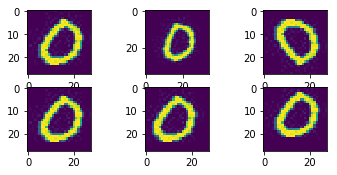

In [262]:
print(mnist_train_paths[0][1])
new_set = mnist_aug(mpimg.imread(mnist_train_paths[10][0]), mnist_train_paths[10][1])

plt.figure()

plt.subplot(331)
plt.imshow(new_set[0][0])
plt.subplot(332)
plt.imshow(new_set[1][0])
plt.subplot(333)
plt.imshow(new_set[2][0])
plt.subplot(334)
plt.imshow(new_set[3][0])
plt.subplot(335)
plt.imshow(new_set[4][0])
plt.subplot(336)
plt.imshow(new_set[5][0])


In [98]:
test_array = np.array([[(0, 1), (1, 2)], [(-1, 3), (3, 1)]])
print(np.shape(test_array))
test_array_flatten = np.ravel(test_array)
test_array_flatten
test_array_reshape = np.reshape(test_array, (4, 2))
test_array_reshape

(2, 2, 2)


array([[ 0,  1],
       [ 1,  2],
       [-1,  3],
       [ 3,  1]])

In [263]:
# Now we generate a larger training set!
full_mnist_train_paths = np.reshape([mnist_aug(mpimg.imread(image), label) for image, label in mnist_train_paths], (480*8, 2))
np.shape(full_mnist_train_paths)

(3840, 2)

In [264]:
np.shape(full_mnist_train_paths[56][0])

(28, 28)

In [265]:
mnist_train_paths = full_mnist_train_paths
# Normalize the validation paths to be at 1.0
mnist_val_paths = [(mpimg.imread(path)/np.float(255), label) for path, label in mnist_val_paths]


In [266]:
print(np.shape(mnist_val_paths))

# Finally we resize the images to 299 x 299 so the validation classifier can read it. 
height = 299
width = 299
mnist_val_paths = [(imresize(path ,(height, width)), labels) for path, labels in mnist_val_paths]

print(np.shape(mnist_val_paths[0][0]))

(120, 2)
(299, 299)


In [267]:
np.random.seed(42)
import matplotlib.image as mpimg
from scipy.misc import imresize 
from random import sample

height = 299
width = 299
channels = 3 # need 3 channels -- just make 3 copies of the data in a channel dimension. 

def prep_batches(mnist_paths, batch_size):
    batch_mnist_paths = sample(list(mnist_paths), batch_size)
    padded_images = [imresize(path,(height, width)) for path, labels in batch_mnist_paths]
    channel_images =[np.stack([padded_images[item], padded_images[item], padded_images[item]], axis = 2) for item in range(len(padded_images))]
    #images = [np.reshape(channel_images)[:, :, :channels] for path, labels in batch_mnist_paths]
    #final_images = [data_crop_and_aug(image) for image in images]
    X_batch = 2*np.stack(channel_images) -1
    y_batch = np.array([labels for path, labels in batch_mnist_paths],dtype = np.int32)
    return X_batch, y_batch

In [274]:
# Stack the paths to lie between -1 and 1.

X_val =  2*np.stack([np.stack([array, array, array], axis=2) for array, labels in mnist_val_paths])-1
y_val  = np.array([labels for array, labels in mnist_val_paths], dtype = np.int32)


In [272]:
y_val[0:20]

array([4, 9, 8, 7, 1, 3, 7, 9, 9, 3, 5, 2, 1, 4, 3, 1, 6, 0, 0, 6], dtype=int32)

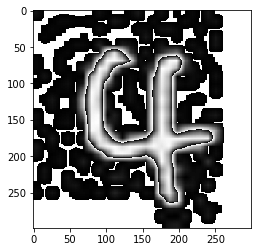

In [277]:
X_val[0].shape


plt.imshow(X_val[0])

# 299*299*3 image.

(10, 299, 299, 3)


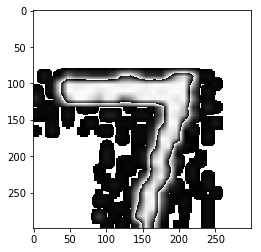

In [276]:
X_batch, y_batch = prep_batches(mnist_train_paths, batch_size= 10)
y_batch

print(np.shape(X_batch))

plt.imshow(X_batch[9])

In [278]:
# Now we import the already pre-trained Inception v3 and train this on MNIST and our final image dataset. To do so,
# we follow the approach taken in the flowers dataset. 
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import inception


tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape = [None, height, width, channels], name = "X")
training = tf.placeholder_with_default(False, shape = [], name = 'training')

with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes = 1001, is_training = training)
# is training makes sure training is true. -- make sure to set this.
inception_saver = tf.train.Saver()

prelogits = tf.squeeze(end_points["PreLogits"], axis = [1, 2])

n_outputs = 10

y = tf.placeholder(tf.int32, shape = [None], name = "y")

mnist_logits = tf.layers.dense(prelogits, n_outputs, name = "mnist_logits")
y_proba = tf.nn.softmax(mnist_logits, name = "y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = mnist_logits, labels = y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    mnist_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = "mnist_logits")
    training_op = optimizer.minimize(loss, var_list = mnist_vars)

with tf.name_scope("correct"):
    correct = tf.nn.in_top_k(mnist_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [ ]:
end_points

In [279]:
batch_size = 50
n_epochs = 50
n_batches = len(mnist_train_paths)//batch_size

print(len(mnist_train_paths))
n_batches

3840


76

In [280]:
my_path = os.getcwd()
print(my_path)
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(my_path, "inception_v3.ckpt")

/Users/stefan/Python_notebooks


In [ ]:
#tf.reset_default_graph()
acc_epoch = np.zeros((n_epochs), dtype = float)
epoch_loss = np.zeros((n_epochs), dtype = float)
train_epoch = np.zeros((n_epochs), dtype = float)
val_epoch = np.zeros((n_epochs), dtype = float)

with tf.Session() as sess:
    
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("epoch =", epoch)
        for iterator in range(n_batches):
            X_batch, y_batch = prep_batches(mnist_train_paths, batch_size = batch_size)
            _, loss_val = sess.run([training_op, loss], feed_dict= {X: X_batch, y: y_batch, training: True})
        acc_train = accuracy.eval(feed_dict= {X: X_batch, y: y_batch, training: True})
        acc_val = accuracy.eval(feed_dict= {X: X_val, y: y_val, training: training})
        val_epoch[epoch] = acc_val
        train_epoch[epoch] = acc_train
        print("Training Accuracy = ", acc_train, "Validation Accuracy=", acc_val)
        
        
    #save_path = saver.save(sess, "./my_mnist_model")
sess.close()

INFO:tensorflow:Restoring parameters from /Users/stefan/Python_notebooks/inception_v3.ckpt
epoch = 0


In [188]:
fig_paths = os.path.join(my_path, "MNIST_inception_training_acc.png")
fig_paths

'/Users/stefan/Python_notebooks/MNIST_inception_training_acc.png'

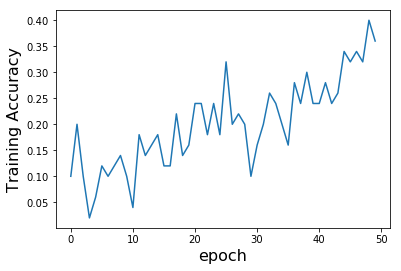

In [189]:
prev_train_epoch = train_epoch
plt.plot(train_epoch)
plt.xlabel('epoch', fontsize = 16)
plt.ylabel('Training Accuracy', fontsize = 16)
plt.savefig(fig_paths)

In [ ]:
mylist = np.zeros(5)

for epoch in range(5):
    mylist[epoch] = epoch

mylist

In [ ]:
# Now we apply the transfer learning on Inception to the Traffic Signs dataset. 

In [196]:
import os
PATH = os.getcwd()
n_channels = 3

In [197]:
# Next we implement the inception on the German traffic signs dataset.

traffic_root_path = os.path.join(PATH, 'GTSRB/Final_Training/Images')

traffic_classes = sorted([dirname for dirname in os.listdir(traffic_root_path)
                         if os.path.isdir(os.path.join(traffic_root_path, dirname))])
#traffic_classes

In [198]:
# Next we list the image file paths for each class.

from collections import defaultdict

image_paths = defaultdict(list)

for traffic_signs in traffic_classes:
    image_dir = os.path.join(traffic_root_path, traffic_signs)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".ppm"):
            image_paths[traffic_signs].append(os.path.join(image_dir, filepath))

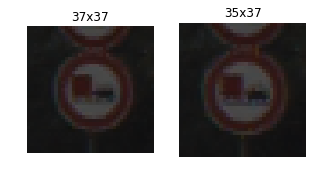

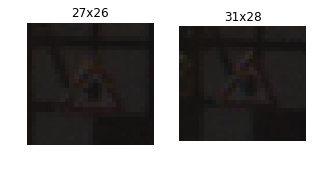

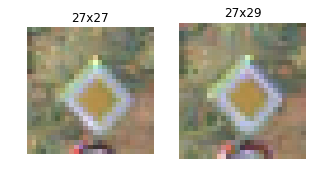

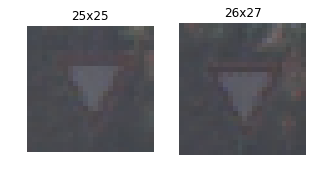

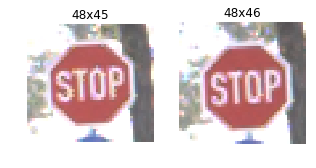

In [199]:
# Next we see if we are getting the pictures we want. Image Paths is a dictionary and must be called as such.

import matplotlib.image as mpimg

images_per_class = 2

for traffic_class in traffic_classes[10:15]:
    plt.figure(figsize = (5, 5))
    for index, filename in enumerate(image_paths[traffic_class][:images_per_class]):
        my_image = mpimg.imread(filename)[:, :, :n_channels]
        plt.subplot(100 + images_per_class * 10 + index + 1)
        plt.title("{}x{}".format(my_image.shape[1], my_image.shape[0]))
        plt.imshow(my_image)
        plt.axis("off")
    plt.show()                                            

In [ ]:
# Notice all image are different sizes. We will perform random transformations on these images and feed a constant size
# to the neural network.

In [200]:
img_sizes = []

for traffic_class in traffic_classes:
    for index, filename in enumerate(image_paths[traffic_class]):
        my_image = mpimg.imread(filename)[:, :, :n_channels]
        img_sizes.append([my_image.shape[0], my_image.shape[1]])

In [201]:
mean_dims = np.mean(img_sizes, axis=0).astype(int)
mean_dims

array([50, 50])

In [202]:
# So the average size is 50 x 50, and we convert the dataset to a uniform standard. 

height = 299
width = 299
channels = n_channels
ave_size = 50

# we need to scale and convert images to 299x299 for Inception.

In [245]:
from scipy.misc import imresize 
from scipy import ndimage
from scipy.ndimage.interpolation import shift


#def shift_image(image, dx, dy):
#    shifted_image = shift(image[:, :, channels], [dy, dx], cval=0, mode="constant")
#    print("worked")
#    return shifted_image.reshape([-1])

# Convert images to squares. Add random noise, rotate image, flip image vertically, and spit out new image.
# We may also generalize this to produce more training examples in the future. 

def img_square(image, zoom = 0.1, target_height = height, target_width = width):
    height = np.shape(image)[1]
    width = np.shape(image)[0]
    img_aspect_ratio = np.shape(image)[1]/np.shape(image)[0]
    check_size  = img_aspect_ratio < 1
    crop_height = height if check_size else width
    crop_width = width if check_size==False else height
    
    # Resize the aspect ratio by a random factor > 1
    resize_factor = np.random.rand() * zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = 0#np.random.randint(0, width - crop_width)
    y0 = 0 #np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    new_image = image[x0:x1, y0:y1]
    new_shape = new_image.shape
    
    if np.random.rand()<0.5:
        angle = np.random.randint(0, 90)
        new_image = ndimage.rotate(image, angle)
    
    if np.random.rand() < 0.5:
        new_image = np.flipud(image)
    
    if np.random.rand() < 0.75:
        noise = np.random.rand()
        new_image = new_image + noise
    
    new_image = imresize(new_image,  (target_height, target_width, 3))
    return new_image/np.float(255)
    

orig shape= (37, 35, 3)
80
0.40448544968185074
0.737855766906525
final shape =  (299, 299, 3)
0.992156862745


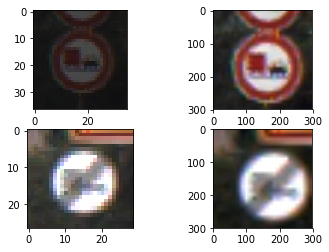

In [243]:
my_test_images  = mpimg.imread(image_paths[traffic_classes[10]][1]), mpimg.imread(image_paths[traffic_classes[42]][1])
print("orig shape=", np.shape(my_test_image))
print(np.max(my_test_image))
final_image = img_square(my_test_images[0])
final_image2 = img_square(my_test_images[1])

print("final shape = ", np.shape(final_image))
print(np.max(final_image))
plt.figure()
plt.subplot(221)
plt.imshow(my_test_images[0])
plt.subplot(222)
plt.imshow(final_image)
plt.subplot(223)
plt.imshow(my_test_images[1])
plt.subplot(224)
plt.imshow(final_image2)
plt.show()

In [219]:
# Now we create a training dataset and a validation dataset. Training set is then shuffled for batch norm.
traffic_class_paths = []

for traffic in traffic_classes:
    for index, path in enumerate(image_paths[traffic]):
        image_dir = os.path.join(traffic_root_path, traffic)
        traffic_class_paths.append((os.path.join(image_dir, path), traffic))
            

In [232]:
# Shuffle the dataset before splitting into training and validation
np.random.seed(42)
from random import shuffle

shuffle(traffic_class_paths)

In [235]:
train_val_split = 0.2
train_size = int(len(traffic_class_paths)*(1-train_val_split))

train_set = traffic_class_paths[:train_size]
val_set = traffic_class_paths[train_size:]

print(len(train_set), len(val_set))
train_set[:1]

31367 7842


[('/Users/stefan/Python_notebooks/GTSRB/Final_Training/Images/00017/00004_00001.ppm',
  '00017')]

In [236]:
X_val = [imresize(mpimg.imread(path)/np.float(255), (height, width, channels)) for path, label in val_set]
y_val = np.array([label for path, label in val_set], dtype = np.int32)

In [237]:
np.shape(X_val[0])

y_val[0:15]

# We have generated a random validation set!

array([25,  7, 38, 13,  9, 11,  5,  5, 12,  8,  2, 13, 16, 25, 13], dtype=int32)

In [238]:
from random import sample

def get_batches(dataset, batch_size):
    train_batch_paths = sample(dataset, batch_size)
    train_batches = [mpimg.imread(path)[:, :, :channels].astype(np.float32) for path, labels in train_batch_paths]
    final_train_batches  = [img_square(item) for item in train_batches]
    # Normalize and zero mean the batches. 
    # If the images are being fed into Inception v3 then, need to stack them from -1 to 1. 
    train_batches = 2*np.stack(final_train_batches) -1
    y_labels = np.array([labels for paths, labels in train_batch_paths], dtype = np.int32)
    return train_batches, y_labels

In [251]:
# This way we get random batches and labels. 
test_batch  = get_batches(train_set, 100)

test_batch[1]

array([ 6,  1,  1, 12, 12, 12,  2, 20, 35, 12,  7, 10, 11,  1,  2,  2,  8,
       17, 11, 10, 18, 13,  2, 11, 10,  9, 25, 17,  5, 14, 10,  9, 17,  5,
       11, 33, 13, 17,  5, 10, 40, 25, 12, 12, 28, 10, 13, 28, 11, 38, 40,
       11,  4, 18, 11,  1, 15,  9,  9, 13,  2, 15, 10, 21, 30, 12, 22,  8,
        1, 33, 13,  4, 35,  2, 13,  7,  1,  5,  4,  1, 35, 17,  2,  3,  2,
       30,  1, 11, 10,  1,  9,  2, 33,  3, 23,  5,  9,  4, 36, 29], dtype=int32)

In [252]:
initial_learning_rate = 0.001
decay_steps = 10000
decay_rate = 1/10

In [253]:
# Now we are ready to begin training. As before we restart Inception.
# We can now test the model on inceptionv3 to see what kind of training/validation accuracy we get!

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import inception


tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape = [None, height, width, channels], name = "X")
training = tf.placeholder_with_default(False, shape = [], name = 'training')

with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes = 1001, is_training = training)
# is training makes sure training is true. -- make sure to set this.
inception_saver = tf.train.Saver()

prelogits = tf.squeeze(end_points["PreLogits"], axis = [1, 2])

# 42 classes of labels. 
n_outputs = 42

y = tf.placeholder(tf.int32, shape = [None], name = "y")

traffic_logits = tf.layers.dense(prelogits, n_outputs, name = "traffic_logits")
y_proba = tf.nn.softmax(traffic_logits, name = "y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = traffic_logits, labels = y)
    loss = tf.reduce_mean(xentropy)
    global_step = tf.Variable(0, trainable= False)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    mnist_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = "traffic_logits")
    training_op = optimizer.minimize(loss, var_list = mnist_vars)

with tf.name_scope("correct"):
    correct = tf.nn.in_top_k(traffic_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [254]:
my_path = os.getcwd()
print(my_path)
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(my_path, "inception_v3.ckpt")

/Users/stefan/Python_notebooks


In [282]:
batch_size = 100
n_batches = len(train_set)//batch_size
n_epochs = 50
n_batches

313

In [ ]:
acc_epoch = np.zeros((n_epochs), dtype = float)
epoch_loss = np.zeros((n_epochs), dtype = float)
train_epoch = np.zeros((n_epochs), dtype = float)
val_epoch = np.zeros((n_epochs), dtype = float)

with tf.Session() as sess:
    
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("epoch =", epoch)
        for iterator in range(n_batches):
            X_batch, y_batch = get_batches(train_set, batch_size = batch_size)
            _, loss_val = sess.run([training_op, loss], feed_dict= {X: X_batch, y: y_batch, training: True})
        acc_train = accuracy.eval(feed_dict= {X: X_batch, y: y_batch, training: True})
        acc_val = accuracy.eval(feed_dict= {X: X_val, y: y_val, training: training})
        val_epoch[epoch] = acc_val
        train_epoch[epoch] = acc_train
        print("Training Accuracy = ", acc_train, "Validation Accuracy=", acc_val)
        
        
    #save_path = saver.save(sess, "./my_mnist_model")
sess.close()